# Анализ взаимодействия пользователей с игрой
## в рамках учебного проекта курса SDA-38
### студент Ворон А.А.

## Задачи
#### 1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 
Насколько обучение сокращает время прохождения этапов?

#### 2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.

#### 3. Дополнительная задача. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? 
Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.

## Структура решения:
1. Создадим объединенную таблицу, далее будем обращаться только к ней.
2. Создадим несолько функций для повторяющихся действий. Среди них создание множества пользователей по определенным критериям (зарегистрированные, не прошедшие обучение, начавшие, но не закончившие, прошедшие обучение, совершившие покупку и т.д.), вычисление временных интервалов между разными событиями для определенных групп пользователей. 
3. Проведем ряд исследований интервалов по группам пользователей для решения первой задачи.
4. Для решения второй задачи разобьем группу пользователей, прошедших обучение, по количеству обучений и посмотрим покупки каждой подгруппы.
5. Для третьей задачи найдем нужных нам пользователей и сравним их с общим числом.

#### Для начала загрузим исходные таблицы через pandas и создадим единый датафрейм

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings; warnings.simplefilter('ignore') #warning filter disabled

df_events = pd.read_csv('7_4_events.csv')
df_purchase = pd.read_csv('7_4_purchase.csv')

# оставим только пользователей, зарегистрировавшихся в 2018 году
filter1 = df_events['event_type'] == 'registration' # фильтр по событию
filter2 = df_events['start_time'].str[:4] == '2018' # фильтр по году
uid_2018 = set(df_events['user_id'].loc[filter1 & filter2]) # сет uid по фильтрам
df_events = df_events.loc[df_events['user_id'].isin(uid_2018)] # отфильтрованный датафрейм
df_purchase = df_purchase.loc[df_purchase['user_id'].isin(uid_2018)] # заодно отфильтруем датафрейм покупок

# переименуем колонки в более удобный и единый формат
df_events = df_events.rename(columns = {'id':'event_id', 'start_time':'event_time'})
#del df_events['tutorial_id']
df_purchase = df_purchase.rename(columns = {'id':'purchase_id', 'event_datetime':'event_time'})
df_purchase['event_type'] = 'purchase'

# объединяем наши датафреймы
df = pd.concat([df_events, df_purchase], ignore_index=True)
del df_events
del df_purchase

# приведем столбец event_time в нужный формат
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['event_time'])
#print(df.dtypes) # можно проверить форматы

#### Создадим несколько удобных функций. Это увеличит время работы кода, но сделает код более коротким и исключит случайные ошибки при внесении изменений

In [2]:
def users_(x): # Создаем сеты юзеров по событиям
    if x in list(df['event_type'].unique()): # Проверка юзеров по возможным событиям в датафрейме
        return set(df[df['event_type'] == x]['user_id'])
    elif x == 'no_tutorial': # Юзеры, не начавшие обучение
        rega = set(df[df['event_type'] == 'registration']['user_id'])
        tsu = set(df[df['event_type'] == 'tutorial_start']['user_id'])
        return rega.difference(tsu)
    elif x == 'not_finished': # Юзеры, начавшие, но не закончившие обучение
        tsu = set(df[df['event_type'] == 'tutorial_start']['user_id'])
        tfu = set(df[df['event_type'] == 'tutorial_finish']['user_id'])
        return tsu.difference(tfu)
    elif x == 'useless': #Юзеры, которые не совершили никаких действий после регистрации
        rega = set(df[df['event_type'] == 'registration']['user_id'])
        tsu = set(df[df['event_type'] == 'tutorial_start']['user_id']) # нельзя перейти к tutorial_finish, минуя этот шаг
        lc = set(df[df['event_type'] == 'level_choice']['user_id']) # нельзя перейти к последующим гашам, минуя этот
        return rega.difference(tsu,lc)

# Следующая функция получает юзеров из предыдущей функции и события, между которыми нужно получить интервал
# На выходе создает небольшой датафрейм как промежуточное звено на случай необходимости проверки, например, разбега в интервалах по юзерам
def interval_between(group,first_event,second_event):
    df_fil_1 = df.loc[df['user_id'].isin(users_(group).intersection(users_(first_event)))]
    df_fil_1 = df_fil_1.loc[df['event_type'] == first_event]
    df_fil_2 = df.loc[df['user_id'].isin(users_(group).intersection(users_(second_event)))]
    df_fil_2 = df_fil_2.loc[df['event_type'] == second_event]
    df_fil_nd_1 = df_fil_1.sort_values('event_time').drop_duplicates('user_id')
    df_fil_nd_1 = df_fil_nd_1[['user_id','event_time']].rename(columns={'event_time':'start_time'})
    df_fil_nd_2 = df_fil_2.sort_values('event_time').drop_duplicates('user_id')
    df_fil_nd_2 = df_fil_nd_2[['user_id','event_time']].rename(columns={'event_time':'end_time'})
    merged_df = df_fil_nd_1.merge(df_fil_nd_2, on='user_id', how='inner')
    merged_df['delta'] = merged_df['end_time'] - merged_df['start_time']
    merged_df['group'] = group
    return merged_df

describe_interval = lambda a,b,c: interval_between(a,b,c)['delta'].describe().T
mean_interval = lambda a,b,c: interval_between(a,b,c)['delta'].mean()

#Создадим функцию для построения графиков типа boxplot
def boxplot_df(analysing_dict):
    df_new = pd.DataFrame()
    for k,v in analysing_dict.items():
        df_new = pd.concat([df_new,interval_between(k, v[0], v[1])])
    df_new['delta'] = (df_new['delta']/pd.Timedelta('1 hour')).round(2)
    disp_boxplot = sns.boxplot(x = 'group', y = 'delta', data = df_new)
    disp_boxplot = disp_boxplot.set(ylabel = 'interval, hours')
    return plt.show()

# Функция, которая считает долю группы А, дошедших от события B до события C
def semifunnel(A,B,C):
    a = users_(A)
    b = users_(A).intersection(users_(B))
    c = users_(C).intersection(b)
    return len(c)/len(b),len(c),len(b)

### Теперь у нас есть функции, с которыми легко оперировать:
**users_(x)** - создает сеты пользователей по всем имеющимся действиям:  
                registration  
                tutorial_start  
                tutorial_finish  
                level_choice  
                pack_choice  
                а также добавлены сеты, которые помогут нам в дальнейшем анализе:  
                no_tutorial - сет пользователей, которые не начинали обучение  
                not_finished - сет пользователей, которые начали, но не закончили обучение  
  
**interval_between(group, first_event, second_event)**  
                эта функция принимает на входе 3 параметра:  
                **group** - это сет пользователей, который нам интересен. Повторяет предыдущую ф-ю  
                **first_event** - начальное событие для вычисления интервала (из event_type)  
                **second_event** - конечное событие для вычисления интервала  
                На выходе получаем небольшой датафрейм с 4-мя колонками:  
                *user_id* - id юзеров нужной группы, которые прошли до конца выбранный интервал  
                *start_time* - время начального события  
                *end_time* - время конечного события  
                *delta* - интересующий нас интервал  
                *group* - название группы, которое пригодится нам для построения графиков
  
**describe_interval** - предыдущая ф-я, но с применением метода describe для колонки с интервалом  
  
**mean_interval** - аналогично, но считаем только среднее значение (метод mean)  
  
**boxplot_df** - наша функция для построения графиков. Принимает словарь, построенный по принципу: ключ = группа, значение - список из двух позиций: начальное и конечное событие. Показывает boxplot, где ось X - это группа пользователей, ось Y - это интервал между событиями в часах  
  
**semifunnel** - задаем интересующую нас группу (A), начальное (B) и конечное (C) событие. Функция возвращает долю пользователей из этой группы, дошедших до события С после события В (неформатированную), количество пользователей на событии С и на событии В - кортеж (C/B, C, B)  

# Приступим к решению первой задачи  
*Цель: сравнить время прохождения различных этапов для пользователей, которые прошли обучение и отказались от него*  
  
Для начала проверим, насколько интерфейс настроен на то, чтобы пользователь сразу пошел проходить обучение. Для этого сравним время между регистрацией и началом обучения у тех, кто начал обучение, и между регистрацией и выбором уровня сложности тех, кто решил пропустить обучение.

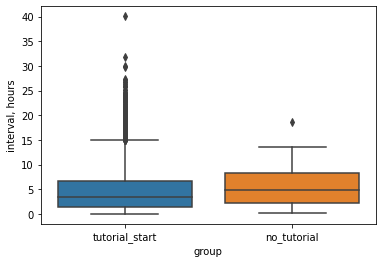

In [3]:
analysing = {
    'tutorial_start':['registration','tutorial_start'],
    'no_tutorial':['registration','level_choice']
}
boxplot_df(analysing)

Видно, что обучение найти достаточно легко, но и перейти к выбору уровня сложности совсем несложно. Видимо, эти опции находятся в одном списке меню. Пока это и не плохо, и не хорошо. Проанализируем поведение пользователей дальше. Если прохождение обучения заметно влияет на пользователей в дальнейшем, имеет смысл изменить меню, чтобы переход к обучению был более навязчивым.  
  
Посмотрим, отличается ли время между регистрацией и выбором уровня сложности для тех, кто не проходил обучения, начал, но не закончил, и тех, кто прошел обучение до конца.

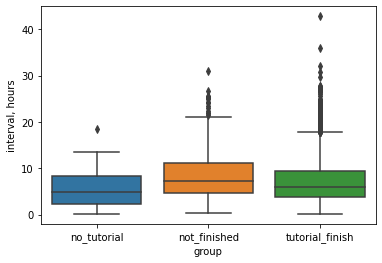

Средний интервал между событиями registration и level_choice в группе no_tutorial равен
	0 days 05:15:33.122448979
	От registration до level_choice дошли 1.21% пользователей (98 из 8068)

Средний интервал между событиями registration и level_choice в группе not_finished равен
	0 days 08:12:57.551816958
	От registration до level_choice дошли 46.21% пользователей (743 из 1608)

Средний интервал между событиями registration и level_choice в группе tutorial_finish равен
	0 days 07:05:36.854819357
	От registration до level_choice дошли 73.18% пользователей (7501 из 10250)



In [4]:
analysing = {
    'no_tutorial':['registration','level_choice'],
    'not_finished':['registration','level_choice'],
    'tutorial_finish':['registration','level_choice']
}
boxplot_df(analysing)
for k,v in analysing.items():
    print(f'Средний интервал между событиями {v[0]} и {v[1]} в группе {k} равен\n\t{mean_interval(k,v[0],v[1])}')
    print(f'\tОт {v[0]} до {v[1]} дошли {semifunnel(k,v[0],v[1])[0]:.2%} пользователей ({semifunnel(k,v[0],v[1])[1]} из {semifunnel(k,v[0],v[1])[2]})\n')

Любопытно! Похоже, что пользователи, которые не проходили обучение, включаются в игру гораздо быстрее тех, кто его хотя бы начал! 
  
Это логично - вместо того, чтобы проходить обучение, первая группа пользователей сразу переходит к уровню сложности. Такой график совсем непоказательный. Нужно сравнивать выбор уровня сложности с предыдущим действием пользователя.

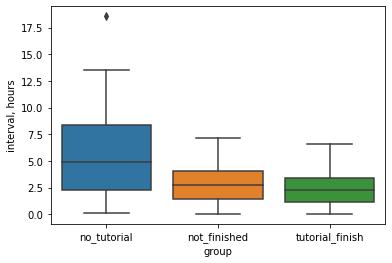

In [5]:
analysing2 = {
    'no_tutorial':['registration','level_choice'],
    'not_finished':['tutorial_start','level_choice'],
    'tutorial_finish':['tutorial_finish','level_choice']
}
boxplot_df(analysing2)

Это уже интересно. Взглянем на цифры:

In [6]:
for k,v in analysing2.items():
    print(f'Средний интервал между событиями {v[0]} и {v[1]} в группе {k} равен\n\t{mean_interval(k,v[0],v[1])}')
    print(f'\tОт {v[0]} до {v[1]} дошли {semifunnel(k,v[0],v[1])[0]:.2%} пользователей ({semifunnel(k,v[0],v[1])[1]} из {semifunnel(k,v[0],v[1])[2]})\n')

Средний интервал между событиями registration и level_choice в группе no_tutorial равен
	0 days 05:15:33.122448979
	От registration до level_choice дошли 1.21% пользователей (98 из 8068)

Средний интервал между событиями tutorial_start и level_choice в группе not_finished равен
	0 days 02:47:28.088829071
	От tutorial_start до level_choice дошли 46.21% пользователей (743 из 1608)

Средний интервал между событиями tutorial_finish и level_choice в группе tutorial_finish равен
	0 days 02:19:46.959472070
	От tutorial_finish до level_choice дошли 73.18% пользователей (7501 из 10250)



#### Предварительный вывод по первой проверке   
  
  
Оказывается, те пользователи, кто хотя бы начал обучение, переходят к выбору уровня сложности вдвое быстрее тех, кто решил сразу перейти к игре!  
  
Мы видим, насколько невероятно низкий процент пользователей, не прошедших обучение, дошел до выбора уровня сложности. Но почему? Как такое возможно, ведь у пользователя есть всего 2 пути: начать обучение или выбрать уровень сложности?   
  
Так же видно, что закончившие обучение, гораздо охотнее продолжают играть. 73% против 46% из незакончивших обучение.  
  
Проверим, как обучение влияет на последующие этапы. Но перед этим взглянем, много ли людей не заинтересовались игрой с первого взгляда?  

In [7]:
print(f"Всего зарегистрировавшихся пользователей: {len(users_('registration'))}")
print(f"из них:\nне прошедших обучение: {len(users_('no_tutorial'))}\nначавших, но не закончивших: {len(users_('not_finished'))}\nпрошедших обучение: {len(users_('tutorial_finish'))}")
print(f"сумма совпадает: {len(users_('registration')) == len(users_('no_tutorial')) + len(users_('not_finished')) + len(users_('tutorial_finish'))}")

useless_users_percent = len(users_('useless'))/len(users_('registration'))
print(f"\nЗарегистрированные пользователи, которые не совершили никаких действий: {len(users_('useless'))} ({useless_users_percent:.2%})")

Всего зарегистрировавшихся пользователей: 19926
из них:
не прошедших обучение: 8068
начавших, но не закончивших: 1608
прошедших обучение: 10250
сумма совпадает: True

Зарегистрированные пользователи, которые не совершили никаких действий: 7970 (40.00%)


Вот и ответ. Почти 8 тысяч человек зарегистрировались, но больше не совершили никаких действий!  
  
**Вопрос, почему 2 из 5 зарегистрировавшихся покидает игру сразу после регистрации адресуем дизайнерам :)**  
  
Идем дальше. Интервалы между выбором уровня сложности и пакетом вопросов.  

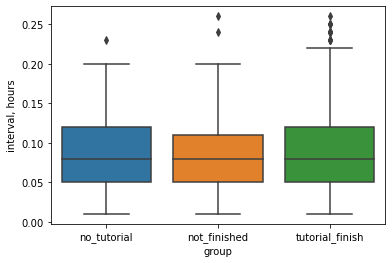

Средний интервал между событиями level_choice и pack_choice в группе no_tutorial равен
	0 days 00:05:23.824324324
	От level_choice до pack_choice дошли 75.51% пользователей (74 из 98)

Средний интервал между событиями level_choice и pack_choice в группе not_finished равен
	0 days 00:05:05.295687885
	От level_choice до pack_choice дошли 65.55% пользователей (487 из 743)

Средний интервал между событиями level_choice и pack_choice в группе tutorial_finish равен
	0 days 00:05:18.146058732
	От level_choice до pack_choice дошли 69.00% пользователей (5176 из 7501)



In [8]:
analysing3 = {
    'no_tutorial':['level_choice','pack_choice'],
    'not_finished':['level_choice','pack_choice'],
    'tutorial_finish':['level_choice','pack_choice']
}
boxplot_df(analysing3)

for k,v in analysing3.items():
    print(f'Средний интервал между событиями {v[0]} и {v[1]} в группе {k} равен\n\t{mean_interval(k,v[0],v[1])}')
    print(f'\tОт {v[0]} до {v[1]} дошли {semifunnel(k,v[0],v[1])[0]:.2%} пользователей ({semifunnel(k,v[0],v[1])[1]} из {semifunnel(k,v[0],v[1])[2]})\n')

Время между выбором уровня сложности и бесплатным пакетом вопросов у всех групп примерно одинаковое - чуть больше 5 минут.  
Среди пользователей, не проходивших обучение, процент дошедших до этого этапа даже немного выше.  
  
Посмотрим на последний шаг - переход от бесплатных вопросов к платным.  

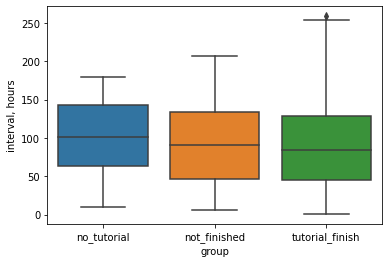

Средний интервал между событиями pack_choice и purchase в группе no_tutorial равен
	4 days 04:49:33.590909090
	От pack_choice до purchase дошли 29.73% пользователей (22 из 74)

Средний интервал между событиями pack_choice и purchase в группе not_finished равен
	3 days 21:14:46.908396946
	От pack_choice до purchase дошли 26.90% пользователей (131 из 487)

Средний интервал между событиями pack_choice и purchase в группе tutorial_finish равен
	3 days 17:17:59.641326883
	От pack_choice до purchase дошли 27.96% пользователей (1447 из 5176)

Факт начала обучения сокращает время между выбором пакета вопросов и покупкой 
на 0 days 07:34:46.682512144 (7.52%)
Прохождение обучения сокращает время между выбором пакета вопросов и покупкой 
на 0 days 11:31:33.949582207 (11.43%)


In [9]:
analysing4 = {
    'no_tutorial':['pack_choice','purchase'],
    'not_finished':['pack_choice','purchase'],
    'tutorial_finish':['pack_choice','purchase']
}
boxplot_df(analysing4)

answer = []  # Сюда сохраним интервалы между событиями, чтобы посчитать разницу между ними
for k,v in analysing4.items():
    print(f'Средний интервал между событиями {v[0]} и {v[1]} в группе {k} равен\n\t{mean_interval(k,v[0],v[1])}')
    print(f'\tОт {v[0]} до {v[1]} дошли {semifunnel(k,v[0],v[1])[0]:.2%} пользователей ({semifunnel(k,v[0],v[1])[1]} из {semifunnel(k,v[0],v[1])[2]})\n')
    answer.append(mean_interval(k,v[0],v[1]))

print(f'Факт начала обучения сокращает время между выбором пакета вопросов и покупкой \nна {answer[0]-answer[1]} ({(answer[0]-answer[1])/answer[0]:.2%})')
print(f'Прохождение обучения сокращает время между выбором пакета вопросов и покупкой \nна {answer[0]-answer[2]} ({(answer[0]-answer[2])/answer[0]:.2%})')
    

На этапе от бесплатных вопросов до покупки мы видим уже другую тенденцию. На графике это не так заметно, но в цифрах уже ощутимо: Законченное **обучение сокращает время** от выбора бесплатного пакета вопросов до покупки **более чем на 11%**  
  
Проверим время всего пути пользователя от регистрации до покупки по группам и узнаем, сколько процентов пользователей каждой группы дошли до покупки.  

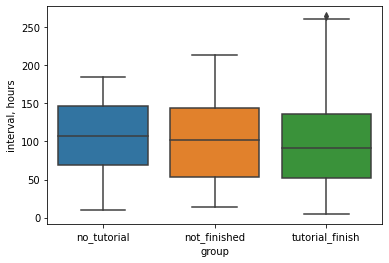

Средний интервал между событиями registration и purchase в группе no_tutorial равен
	4 days 09:06:01.909090909
	От registration до purchase дошли 0.27% пользователей (22 из 8068)

Средний интервал между событиями registration и purchase в группе not_finished равен
	4 days 05:32:53.213740458
	От registration до purchase дошли 8.15% пользователей (131 из 1608)

Средний интервал между событиями registration и purchase в группе tutorial_finish равен
	4 days 00:30:03.247408431
	От registration до purchase дошли 14.12% пользователей (1447 из 10250)

Факт начала обучения сокращает время между регистрацией и покупкой 
на 0 days 03:33:08.695350451 (3.38%)
Прохождение обучения сокращает время между регистрацией и покупкой 
на 0 days 08:35:58.661682478 (8.18%)

Среднее время прохождения обучения (средний интервал между событиями tutorial_start и tutorial_finish) в группе tutorial_finish равен	0 days 00:12:13.823121951


In [10]:
analysing5 = {
    'no_tutorial':['registration','purchase'],
    'not_finished':['registration','purchase'],
    'tutorial_finish':['registration','purchase']
}
boxplot_df(analysing5)

answer1 = []  # Сюда сохраним интервалы между событиями, чтобы посчитать разницу между ними
for k,v in analysing5.items():
    print(f'Средний интервал между событиями {v[0]} и {v[1]} в группе {k} равен\n\t{mean_interval(k,v[0],v[1])}')
    print(f'\tОт {v[0]} до {v[1]} дошли {semifunnel(k,v[0],v[1])[0]:.2%} пользователей ({semifunnel(k,v[0],v[1])[1]} из {semifunnel(k,v[0],v[1])[2]})\n')
    answer1.append(mean_interval(k,v[0],v[1]))

print(f'Факт начала обучения сокращает время между регистрацией и покупкой \nна {answer1[0]-answer1[1]} ({(answer1[0]-answer1[1])/answer1[0]:.2%})')
print(f'Прохождение обучения сокращает время между регистрацией и покупкой \nна {answer1[0]-answer1[2]} ({(answer1[0]-answer1[2])/answer1[0]:.2%})')

analysing6 = {
    'tutorial_finish':['tutorial_start','tutorial_finish']
}

for k,v in analysing6.items():
    print(f'\nСреднее время прохождения обучения (средний интервал между событиями {v[0]} и {v[1]}) в группе {k} равен\t{mean_interval(k,v[0],v[1])}')

Как видно, обучение влияет на на общее время от регистрации до покупки - разница в группах около 8 с половиной часов, включая время на само обучение (сокращает время от регистрации до покупки на 8%). Разница заметна, но не критична.  
  
**Нельзя игнорировать обучение. Оно мало влияет на временные интервалы, но всего 12 минут обучения увеличивают конверсию в 52 раза!**  
  
Однако, вспомним, что в группу не прошедших обучение входит армия мертвых юзеров. Посмотрим, так ли все страшно на самом деле?  

In [11]:
real_no_tutorial = users_('no_tutorial').difference(users_('useless'))
no_tutorial_purchase = users_('no_tutorial').intersection(users_('purchase'))
print(f'Конверсия реальных пользователей, не прошедших обучение, в покупателей составляет {len(no_tutorial_purchase)/len(real_no_tutorial):.2%}')

Конверсия реальных пользователей, не прошедших обучение, в покупателей составляет 22.45%


Любопытная цифра! У нас была гипотеза, что обучение прямо влияет на конверсию в покупки, но **получили противоположный результат**!  
Среди игроков, не начинавших обучение, конверсия составляет 22% против 14% у закончивших обучение. Впрочем, таких пользователей слишком мало, чтобы полностью доверять данным - всего 22 пользователя.

# Перейдем к решению второй задачи
*Цель: определить зависимость покупок от количества пройденных обучений. Доказать, что успешное обучение стимулирует покупки*.

Чуть выше мы уже определили, что пользователи, которые прошли обучение, совершают покупки чаще, чем те, кто его не закончил. Также мы выяснили, что среди всех пользователей, не приступивших к обучению, конверсия в покупки очень маленькая. Однако, если отбросить мертвые души, и смотреть только на пользователей, которые не прошли обучение, но при этом пошли дальше по этапам, то конверсия в покупки оказалась даже выше, чем у прошедших обучение.  
  
Посмотрим более детально на пользователей, прошедших обучение, и посчитаем их конверсию в покупателей.  

14.26% пользователей, прошедших 1 обучение, совершили покупки
13.78% пользователей, прошедших 2 обучения, совершили покупки
12.75% пользователей, прошедших 3 обучения, совершили покупки
10.67% пользователей, прошедших 4 обучения, совершили покупки
16.24% пользователей, прошедших 5 обучений, совершили покупки
14.85% пользователей, прошедших 6 обучений, совершили покупки
15.46% пользователей, прошедших 7 обучений, совершили покупки
11.11% пользователей, прошедших 8 обучений, совершили покупки
18.18% пользователей, прошедших 9 обучений, совершили покупки


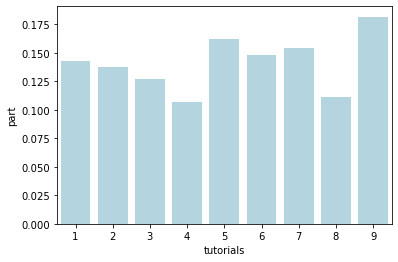

In [12]:
# создаем датафрейм, в котором будут сгруппированы uid и количество обучений
count_tutorials = df.loc[df['event_type'] == 'tutorial_finish'].groupby('user_id').count().reset_index().sort_values('event_type')
count_tutorials = count_tutorials[['user_id','event_type']].rename(columns={'event_type':'num_of_tutorials'})
num_tutorials = set(count_tutorials['num_of_tutorials']) # множество всех возможных количеств обучений (больше нуля)
# превратим датафрейм в словарь, а значения в словаре в привычное множество
count_tutorials = count_tutorials.groupby('num_of_tutorials')['user_id'].unique().to_dict()
for i in num_tutorials:
    count_tutorials[i] = set(count_tutorials[i])

# запускаем цикл, чтобы увидеть все в цифрах, заодно соберем результат в список для визуализации
result = []
for i in num_tutorials:
    tut_users_purch = count_tutorials[i].intersection(users_('purchase')) # юзеры, совершившие покупку
    # плюс небольшой блок для красоты
    if i == 1:
        ending = 'е'
    elif i in (2,3,4):
        ending = 'я'
    else:
        ending = 'й'
    print(f'{len(tut_users_purch)/len(count_tutorials[i]):.2%} пользователей, прошедших {i} обучени{ending}, совершили покупки')
    result.append((i,len(tut_users_purch)/len(count_tutorials[i])))
    
# превратим список в датафрейм для визуализации
result = pd.DataFrame(result,columns=['tutorials','part'])
sns.barplot(x = 'tutorials', y = 'part', data = result, color = 'lightblue')
plt.show()

### Как видно, количество пройденных обучений никак не влияет на покупки.  
Например, пользователи, прошедшие обучение 8 раз, реже совершают покупки, чем пользователи, прошедшие обучение лишь единожды. При этом после 5 обучений покупки совершают чаще, чем после 4.

# Перейдем к третьей задаче
*Цель: узнать, как часто пользователи начинают обучение уже после выбора уровня сложности*

1386 пользователей перешли к обучению после выбора уровня сложности.
Это 6.96% от всех зарегистрировавшихся пользователей
и 11.59% от реально играющих (за вычетом тех, кто только зарегистровался)


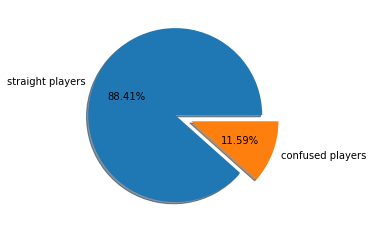

In [13]:
# создадим датафрейм всех пользователей, которые выбрали уровень сложности и начали обучение
lvl_c = df[df['event_type'] == 'level_choice'].rename(columns={'event_time':'start_time'})
tut_s = df[df['event_type'] == 'tutorial_start'].rename(columns={'event_time':'end_time'})
merged_df = lvl_c[['user_id','start_time']].merge(tut_s[['user_id','end_time']],on='user_id',how='inner')
merged_df['delta'] = merged_df['end_time'] - merged_df['start_time']
merged_df = merged_df[merged_df['delta'] >= '0'].drop_duplicates('user_id') # исключим отрицательные интервалы, т.к. это обычный путь пользователя, и уберем повторения
confused_users = set(merged_df['user_id']) 
# теперь у нас есть множество пользователей, которые перешли к обучению после выбора уровня сложности

print(f"{len(confused_users)} пользователей перешли к обучению после выбора уровня сложности.\nЭто {len(confused_users)/len(users_('registration')):.2%} от всех зарегистрировавшихся пользователей\nи {len(confused_users)/len(users_('registration').difference(users_('useless'))):.2%} от реально играющих (за вычетом тех, кто только зарегистровался)")
plt.pie([len(users_('registration').difference(users_('useless')))-len(confused_users),len(confused_users)],explode=(0,0.2),labels=['straight players','confused players'],shadow=True, autopct='%1.2f%%')
plt.show()

**11.59% играющих пользователей** перешли к обучению после выбора уровня сложности - **достаточно много!**

# ВЫВОДЫ
## Сухие цифры:
#### Пользователей зарегистрировалось: 19926
#### Пользователей, начавших обучение обучение: 11858
Из них:   
Закончивших обучение: 10250  
Не закончивших обучение: 1608  
#### Пользователей, не прошедших обучение, но вступивших в игру: 98
#### Пользователей, не совершивших никаких действий, кроме регистрации: 7970
  
#### Временные интервалы 
| интервал \ группа | без обучения | не закончившие обучение | закончившие обучение |
|---|---|---|---|
|от регистрации до выбора уровня сложности|5:15:33|8:12:57|7:05:36|
|от предыдущего события до выбора уровня сложности|5:15:33|2:47:28|2:19:46|
|от уровня сложности до пакета вопросов|05:23|05:05|05:18|
|от пакета вопросов до покупки|4 дня 04:49:33|3 дня 21:14:46|3 дня 17:17:59|
|от регистрации до покупки|4 дня 09:06:01|4 дня 05:32:53|4 дня 00:30:03|
  
#### Факт начала обучения сокращает время 
между выбором пакета вопросов и покупкой на **7.52%** (7:34:46)  
между регистрацией и покупкой на **3.38%** (3:33:08) 
#### Прохождение обучения сокращает время 
между выбором пакета вопросов и покупкой на **11.43%** (11:31:36)  
между регистрацией и покупкой на **8.18%** (8:35:58)   
#### Среднее время обучения 12 минут 13 секунд
#### Конверсия пользователей в покупателей:
Не прошедших обучение (формальная): **0.27%**  
Не прошедших обучение (**реальная**): **22.45%**  
Не закончивших обучение: **8.15%**  
Прошедших обучение: **14.12%**  
  
## Ответы на поставленные вопросы:
### 1. Проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. Насколько обучение сокращает время прохождения этапов?
Что касается первого шага - от регистрации до выбора уровня сложности - У пользователя есть всего 2 пути - начать обучение или выбрать уровень сложности. Естественно, что если считать от момента регистрации, пользователи, не прошедшие обучение, переходят ко второму этапу гораздо быстрее тех, кто обучение проходит. Если же считать переход к выбору уровня сложности от предшествующего этапа (регистрация, начало обучения, окончание обучения), то обучение играет положительную роль. На мой взгляд этот этап непоказательный, в отличие от сделующих.  
  
Этап от выбора уровня сложности до выбора бесплатного пакета вопросов у всех групп примерно одинаковый - чуть больше 5 минут.  
  
Этап от выбора бесплатного пакета до покупки платного пакета заметно сокращается при обучении. При среднем времени этого интервала в 4 дня, прошедшие обучение пользователи совершают покупку на 11 с половиной часов раньше, чем не проходившие обучение.  
### 2. Посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. Нужно доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
Некоторые пользователи проходили обучение несколько раз (максимально - 9). 
  
| кол-во обучений |1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
| **конверсия в покупки** |14.26%|13.78%|12.75%|10.67%|16.24%|14.85%|15.46%|11.11%|18.18%|
  
Как видно из таблицы, количество пройденных обучений никак не влияет на вероятность оплаты вопросов.    
  
Что же касается связи обучения и факта оплаты...  
8% пользователей, начавших, но не закончивших обучение, совершают покупки.  
14% прошедших обучение пользователей совершают покупки.  
Связь ощутима и заметна. Нужно стимулировать пользователей доходить до конца обучения.  
  
В части пользователей, не проходивших обучение, ответ не так однозначен.  
Формально, лишь 0.27% из них совершают покупки. Это очень низкая конверсия, и конечно нужно стимулировать пользователей проходить обучение.  
На деле большая часть не проходивших обучение пользователей вообще не совершала никаких действий после регистрации, а среди тех, кто включился в игру конверсия составляет больше **22%**, т.е. выше, чем у прошедших обучение!
### 3. Дополнительная задача. Как часто пользователи начинают обучение после того, как они выбрали уровень сложности? Это позволит нам понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.
1386 пользователей перешли к обучению после выбора уровня сложности.
Это 6.96% от всех зарегистрировавшихся пользователей
и **11.59%** от реально играющих (за вычетом тех, кто только зарегистровался).   
Это высокий показатель. Значит, либо игра сама по себе очень сложная, либо интерфейс приложения непонятный.

## Заключение
Логика подсказывает, что регистрация - это самый простой этап. Если человек регистрируется, значит, он хочет попробовать поиграть. Однако, 40% зарегистрировавшихся так и не совершили более никаких действий. Это очень печальная цифра. Мне видятся 3 возможные причины этого:
+ регистрация проходит в стороннем приложении, например в рекламе. Пользователь регистрируется, но остается в приложении, и после уже не возвращается к игре. В этом случае нет поводов для волнений, просто нужно исключать мертвые души из анализа, а в рекламе делать более навязчивый переход к игре, чтобы увеличить конверсию;
+ оформление игры настолько отталкивающее, что после просмотра тизера трейлера (если он есть) пользователь уходит, взглянув на меню. В этом случае нужно полностью менять дизайн игры;
+ игра постоянно виснет или вылетает. Тогда нужно делать проверку на лаги и запускать новый билд.  
  
Количество пройденных обучений не влияет на конверсию. Поэтому нет смысла стимулировать пользователей проходить обучение повторно.  
Некоторые пользователи проходили обучение 9(!!!) раз! И более 11% активных пользователей перешли к обучению уже после выбора уровня сложности. Значит, работа с приложением непонятна.
+ либо игра слишком сложная
+ либо интерфейс неудобный  
  
Влияет ли обучение на дальнейшие покупки? Неоднозначный вопрос. Мы видим, что среди пользователей, закончивших обучение, покупки совершаются почти вдвое чаще, чем среди тех, кто начал, но не закончил. Обучение стимулирует к покупке? Или пользователи, начав обучение, теряют к игре интерес? Я думаю, второе. В подтверждение тому конверсия активных пользователей, не проходивших обучение. Она выше, чем у тех, кто обучение закончил - 22% против 14%.